(copt)=

# Задачи комбинаторной оптимизации

Автор(ы):

- [Синченко Семен](https://github.com/SemyonSinchenko)


В [обзоре квантовых алгоритмов](../../qcalgo/ru/quantum_algorithms_overview.html#id2) мы уже касались темы задач, для которых не существует эффективных классических алгоритмов, а сегодня разберем еще больше примеров. В конце кратко обсудим пару способов, как решать такие задачи на классических компьютерах, а также в чем их принципиальные проблемы и ограничения.

Лекция будет построена так:

- задача о максимальном разрезе в графе;
- задача о выделении сообществ в графе;
- задача о Гамильтоновых циклах и коммивояжере;
- задача о рюкзаке;
- жадные алгоритмы;
- метод имитации отжига.

Какого-то сложного кода или больших формул с дираковскими значками из квантовой механики тут не будет, так что можно немного передохнуть, расслабиться и насладиться чтением. Для тех, кто хорошо знаком с задачами целочисленной оптимизации, в этой лекции точно не будет ничего нового, и ее можно будет пропускать, ну или пролистать по диагонали.

## Задача о максимальном разрезе в графе

Мы уже немного говорили об этой задаче в лекции про [модель Изинга](../../problems/ru/ising.html#id3) из-за их очень большого сходства. Но давайте еще раз вспомним, что это за модель такая. Ну и сразу рассмотрим ее максимально общий случай. Итак, у нас есть граф на множестве вершин $V$, связанных множеством ребер $E$. Каждое ребро имеет две инцидентных вершины $u,v$; в общем случае порядок $u,v$ важен, тогда мы говорим о направленном (_directed_) графе. Каждому ребру можно также сопоставить действительное число $w$, тогда у нас будет так называемый _взвешенный_ граф. Наша цель -- разбить множество вершин $V$ на два непересекающихся сообщества $V_1, V_2$. Давайте сформулируем функцию стоимости:

$$
C = \sum_{u,v,w \in E} w (\mathbf{1}(u \in V_1, v \in V_2) + \mathbf{1}(u \in V_2, v \in V_1))
$$

То есть в общем случае это просто сумма всех весов ребер между двумя сообществами. В общем случае эта задача является $NP$-полной. В теории к этой задаче можно также свести любую другую $NP$ задачу за полиномиальное время.

```{figure} /_static/problems/ru/ising/Max-cut.png
:width: 400px
:name: MaxCut2

Иллюстрация задачи о максимальном разрезе в графе
```

## Задача о выделении сообществ в графах

Задача о выделении сообщества в графах это уже более практическая и понятная задача. Она находит применение во многих областях, но одно из самых очевидных применений -- это социология (в том числе анализ социальных сетей), когда мы хотим, анализируя контакты людей, выделить из них сообщества для дальнейшего анализа. Эта задача также является $NP$-трудной, так как существует экспоненциально много способов разбить вершины на множества и при этом для общего случая не существует полиномиального алгоритма решения. Ну и даже если мы найдем какое-то решение, то проверка того, что оно лучшее возможна также лишь за экспоненциальное время. Хотя для этой задачи и известны относительно быстрые приближенные алгоритмы, нам очень трудно понять, насколько хорошее решение они дают для действительно больших графов.

```{note}
Для работы с графами мы будем пользоваться библиотекой `NetworkX`. Она написана на чистом `Python` и плохо подходит для работы с большими графами, зато имеет простой интерфейс и легко устанавливается на любую систему. Ее можно установить из репозитория `PyPI`, используя команду

    pip install networkx

```

Одним из первых известных наборов данных для задачи выделения сообществ является "Клуб каратэ Захари" (Zachary’s Karate Club) {cite}`zachary1977`. Для этого набора данных точно известно, к какому из двух сообществ принадлежит каждая из вершин. В этом клубе карате был внутренний конфликт, и одна часть людей была в группе одного из инструкторов (Mr. Hi), а другая -- в группе администратора (Officer).

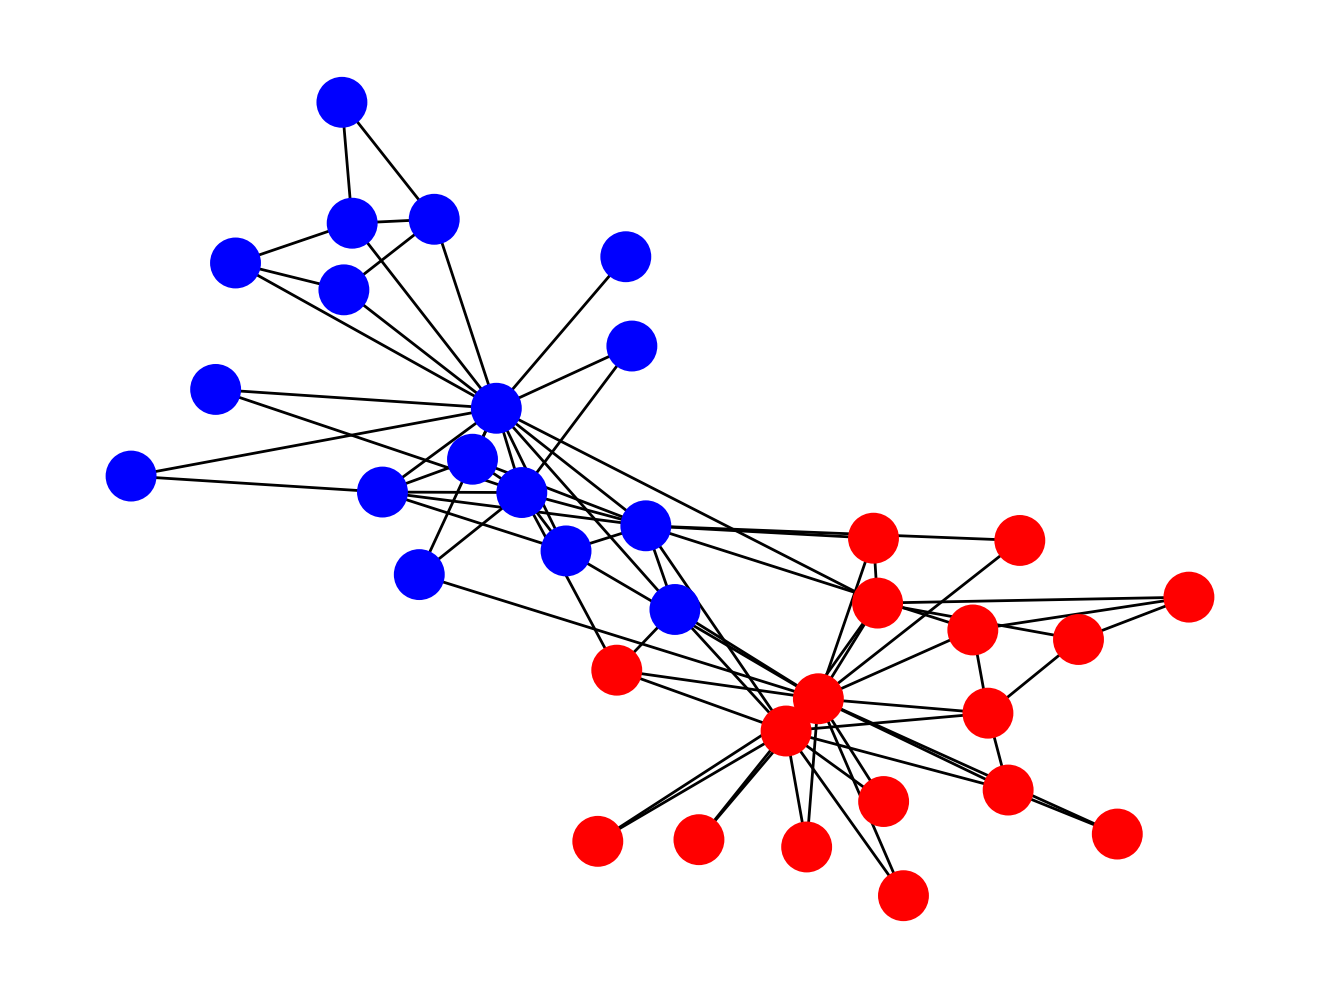

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

zachary = nx.generators.social.karate_club_graph()
nx.draw(
    zachary,
    node_color=[
        {"Officer": "r", "Mr. Hi": "b"}.get(dt["club"]) for _, dt
        in zachary.nodes(data=True)
    ],
)
plt.show()

Задачу о выделении сообществ в тривиальном случае разбиения графа на два подмножества можно свести к знакомой нам задаче о максимальном разрезе. Правда, в отличие от задачи о максимальном разрезе, в случае с сообществами мы хотим иметь минимальное число ребер между ними. Но это можно сделать просто поменяв пару символов в выражении для стоимости:

$$
C = \sum_{u,v,w \in E} w (\mathbf{1}(u \in V_1, v \in V_1) + \mathbf{1}(u \in V_2, v \in V_2))
$$

Но на самом деле мы только что свели более простую задачу о минимальном разрезе с неотрицательными весами к более сложной задаче Max-Cut. А еще выбранная нами метрика (количество ребер) -- не самый лучший вариант для этой задачи. Гораздо лучше подойдет модулярность (modularity), предложенная физиком Марком Ньюманом {cite}`newman_modularity`:

$$
Q(C) = \frac{1}{2 |E|}\sum_{e \in E} B_{e_{src}, e_{dst}}\delta (c_{e_{src}}, c_{e_{dst}})
$$

Тут $B$ -- это матрица модулярности (modularity matrix). Ее элементы определяются через степени $d_i$ соответствующих вершин графа (степень вершины -- это число ребер, связанных с данной вершиной) и матрицу смежности $A$ графа:

$$
B_{ij} = A_{ij} - \frac{d_i d_j}{2 |E|}
$$

Условно, модулярность -- это разница между числом ребер внутри сообществ в нашем графе и числом ребер внутри сообществ в графе с таким же числом ребер, но сгенерированным случайным образом. Это довольно сложное понятие, которое выходит за рамки нашего курса, но все равно потребуется нам, чтобы показать, что задача оптимизации модулярности может быть сформулирована как задача Изинга.

```{note}
Это интересно, но одним из первых алгоритмов для решения задачи о выделении сообществ в графах был алгоритм имитации отжига, который изначально был создан именно для решения проблемы гамильтонианов типа Изинга. Причина заключается в том, что модулярность очень схожа по виду с выражением энергии для магнетиков.
```

Мы тут пока описали лишь простой случай модулярности для не взвешенного и ненаправленного графа. Но даже в таком случае для задачи точной оптимизации модулярности не известно полиномиального алгоритма решения. Поэтому обычно применяют приближенные или жадные алгоритмы, и они вроде даже неплохо работают. Но мы почти не знаем, насколько действительно далеко они от самых оптимальных решений, особенно для больших графов.

## Задача о Гамильтоновых циклах

Перед тем как перейти к интересной и важной задаче поиска Гамильтоновых циклов, мы вспомним задачу о мостах Кенигсберга (Калининграда). Ведь именно гуляя по этому городу и пытаясь решить эту задачу, Леонард Эйлер изобрел теорию графов. Суть задачи: нужно обойти все острова города, пройдя по каждому мосту лишь один раз, и вернуться на тот остров, откуда стартовал. Эйлер, создав математический аппарат теории графов, сумел доказать, что это невозможно, ну а дальше завертелось, и вот мы с вами тут.

```{figure} /_static/problems/ru/copt/bridges.png
:width: 300px

Мосты Кеннингсберга, думая о которых, Эйлер изобрел теорию графов
```

Такой путь в графе, когда мы проходим по каждому ребру лишь один раз, называется Эйлеров цикл. Но нам будет более интересен схожий класс циклов -- Гамильтоновы циклы. Это такие циклы, которые проходят через каждую вершину графа ровно один раз.

```{figure} /_static/problems/ru/copt/Hamilton.jpg
:width: 350px

Сер Уильям Роуэн Гамильтон, 1805 - 1865
```

Для Гамильтонова цикла мы можем ввести $N^2$ бинарных переменных $x_{i,p}$. Каждая переменная $x_{i,p}$ равна $1$, если $i$-я вершина находится на $p$-м шаге пути и $0$ если нет. Тогда легко ввести условия существования такого цикла:

$$
\begin{cases}
\sum_p x_{i,p} = 1 \quad \forall i \\
\sum_i x_{i,p} = 1 \quad \forall p \\
(x_{i, p} = 1) \land (x_{j, p + 1} = 0) \quad \forall i,j \notin E
\end{cases}
$$

Тут первое условие говорит нам о том, что каждая вершина должна попасть в путь. Второе условие -- каждый шаг пути содержит строго одну вершину. Ну а третий шаг -- просто утверждение о том, что между вершинами соседних шагов пути должно быть ребро. На самом деле, эти три условия можно переписать в единую функцию стоимости:

$$
C = (1 - \sum_i x_{i,p})^2 + (1 - \sum_p x_{i,p})^2 + \sum_{u,v \notin E} x_{u,p} x_{v,p+1}
$$

Правда, в этом случае мы должны минимизировать, а не максимизировать эту величину.

## Задача коммивояжера

Задачу коммивояжера мы (а точнее наш смартфон) решаем каждый раз, когда строим в `Google Maps` маршрут, включающий несколько точек. Зная, как формулируется задача о гамильтоновых циклах, сформулировать задачу коммивояжера очень легко.

```{figure} /_static/intro/Salesman.png

Иллюстрация задачи коммивояжера
```

По сути нам требуется взять все Гамильтоновы циклы и выбрать из них тот, для которого сумма весов по содержащимся в нем ребрам будет минимальной. Но надо помнить, что цикл обязательно должен быть в первую очередь Гамильтоновым, поэтому мы добавим веса слагаемых в выражение для стоимости, причем веса, отвечающие за сам цикл, будут больше:

$$
C = A (1 - \sum_i x_{i,p})^2 + A (1 - \sum_p x_{i,p})^2 + A \sum_{u,v \notin E} x_{u,p} x_{v,p+1} + B \sum_{u,v,w \in E} w x_{u,p} x_{v,p+1}
$$

Тут $A,B$ это веса, которые лучше выбирать так, что $0 < Bw < A \quad \forall u,v,w \in E$.

```{note}
Функции стоимости для задач и Гамильтоновых циклах и задачи коммивояжера являются все же приближением исходной формулировки, так как формально мы переходим от задачи с ограничениями к задаче без ограничений. В общем случае нет гарантии, что решение задачи без ограничений будет эквивалентно решению задачи с ограничениям. Но для целей нашей лекции и курса в целом мы опустим сложный момент исследования эквивалентности этих задач, потому что обычно оно работает вполне корректно.
```

## Задача о рюкзаке

Довольно простая для понимания задача, к которой, однако, сводится огромное число куда более сложных задач. Например, именно задачей о рюкзаке является проблема оптимизации портфеля биржевых акций, или, например, оптимизации графиков работы сотрудников McDonald's, учитывая ожидаемое число посетителей и т.д.

Суть задачи заключается в том, что у нас есть рюкзак ограниченного объема. А еще есть набор разных предметов -- каждый из них имеет свой объем и стоимость. Наша цель в данном случае заключается в том, чтобы найти оптимальный набор предметов так, чтобы они влезали в наш рюкзак, при этом их стоимость была бы максимально возможной.

```{figure} /_static/problems/ru/copt/Knapsack.png
:name: knapsack
:width: 450px

Иллюстрация задачи о рюкзаке.
```

Формально это можно записать следующим образом. Пускай у нас есть рюкзак объема $V$. Давайте обозначим количество экземпляров $i$-й вещи в рюкзаке переменной $x_i$, а ее объем $v_i$. Ценность $i$-го предмета обозначим как $s_i$. Решением задачи будет вектор $X$ из целых чисел $x_i$, которые при этом могут быть равны нулю -- это будет значить, что $i$-я вещь не входит в оптимальный набор. Тогда нам необходимо решить следующую задачу:

$$
\begin{cases}
X = \text{argmax} \{ \sum_i x_i \cdot s_i \} \\
\sum_i x_i \cdot w_i \leq W
\end{cases}
$$

## Классические алгоритмы

Самый простой и очевидный вариант решения таких проблем -- это просто перебор всех возможных комбинаций. Но так как сложность задач растет экспоненциально ($O(N) \sim e^{N}$), то очень быстро прямое решение (еще иногда говорят _brute force_ решение, или _brute force_ алгоритм) становится невозможным. Понятно, что можно воспользоваться какими-то эвристиками для конкретной задачи. Это приводит нас к алгоритмам типа _ветвей и границ_ (_branch and bound_) {cite}`land2010automatic`, в которых мы обычно строим дерево возможных решений и пытаемся перебирать не все подряд, а лишь "перспективные" ветви этого дерева, отсекая те ветки, где хороших решений точно не будет. Но сложность таких алгоритмов все равно остается экспоненциальной. Другой вариант -- это искать не обязательно самое лучше решение, а хотя бы какое-то подходящее решение (_feasible solution_, решение, которое удовлетворяет ограничениям). Это приводит нас к аппроксимационным алгоритмам, которые каким-то образом пытаются свести экспоненциальную задачу к полиномиальной, пусть и теряя в гарантированном качестве итогового решения.

```{admonition} Важное замечание
Задачи комбинаторной оптимизации нельзя точно решить на квантовом компьютере! Квантовые компьютеры лишь дают нам потенциально очень эффективные _аппроксимационные_ алгоритмы. Причем в основе этих алгоритмов лежит обычно как раз квантовое машинное обучение!
```

### Общий вид алгоритма ветвей и границ

Давайте запишем как в общем виде выглядит алгоритм ветвей и границ ([источник](https://en.wikipedia.org/wiki/Branch_and_bound#Generic_version)).

1. Найти любое решение $xh$ проблемы, которое бы удовлетворяло ограничениям. Сохраним значение целевой функции для этого решения: $B = f(xh)$. Оно будет определять лучшее из известных на данный момент решений.
2. Инициализировать очередь для хранения частных решений. В этом случае разбиваем пространство возможных решений на маленькие подпространства и строим дерево потенциальных решений. Эта часть индивидуальная для каждой задачи. Например, в случае задачи о рюкзаке, можно взять начальное решение и построить две его ветви: одна будет содержать все решения, где больше одного предмета, а другая -- где его будет меньше.
3. Выполняем итерации, пока наша очередь не пустая.
   - взять узел $N$ из очереди;
   - если узел $N$ представляет собой терминальный узел $x$ дерева и $f(x) < B$, то это новое лучшее известное решение; сохраняем его $B = f(x)$;
   - если нет, то разбиваем $N$ для создания новых узлов $N_i$:
      - если верхняя оценочная граница решений для этой ветки $bound(N_i)$ больше $B$, то ничего не делаем;
      - в противном случае добавляем $N_i$ в очередь.

В данном случае нам необходимо реализовать для конкретной задачи следующие процедуры:

- построения дерева решения
- оценки верхней границы для ветви

В целом, данный алгоритм сегодня это, пожалуй, лучшее, что можем использовать, если нам необходимо точное решение. Также всегда есть опция остановить поиск до того, как мы достигнем оптимума -- в этом варианте алгоритм становится аппроксимационным.

### Жадные алгоритмы

Теперь давайте вернемся к аппроксимационным алгоритмам, которые работают относительно быстро, но, к сожалению, часто дают довольное плохие результаты. Ну и самым простым вариантом таких алгоритмов будет жадный алгоритм. Рассматривать его будем на примере задачи о рюкзаке. Пусть у нас есть рюкзак объема $30$ и набор предметов с их стоимостью и объемом:

$$
items = \{(4, 370), (9, 1950), (10, 3500), (21, 6700), (17, 6100), (3, 800), (27, 8300)\}
$$

In [2]:
capacity = 30
items = [(4, 370), (9, 1950), (10, 3500), (21, 6700), (17, 6100), (3, 800), (27, 8300),]

Наше решение будет максимально простым:

1. считаем удельную стоимость предметов, то есть стоимость единицы их массы;
2. набираем сначала самых дорогих предметов;
3. по остаточному принципу набираем остальные предметы, отдавая предпочтения тем, которые дороже по удельной стоимости.

In [3]:
items_and_score = sorted(
    [(it[0], it[1], it[1] / it[0]) for it in items],
    key=lambda x: x[2],
    reverse=True
)

print("Items, sorted by relative cost:")
for it in items_and_score:
    print(f"Weight: {it[0]}\tCost: {it[1]}\tRelative Cost: {it[2]}")

Items, sorted by relative cost:
Weight: 17	Cost: 6100	Relative Cost: 358.8235294117647
Weight: 10	Cost: 3500	Relative Cost: 350.0
Weight: 21	Cost: 6700	Relative Cost: 319.04761904761904
Weight: 27	Cost: 8300	Relative Cost: 307.4074074074074
Weight: 3	Cost: 800	Relative Cost: 266.6666666666667
Weight: 9	Cost: 1950	Relative Cost: 216.66666666666666
Weight: 4	Cost: 370	Relative Cost: 92.5


"Заполняем" рюкзак:

In [4]:
solution = []
w = capacity
min_weight = min([it[0] for it in items_and_score])

while True:
    if w < min_weight:
        break
    else:
        cand = [it for it in items_and_score if it[0] <= w][0]
        solution.append(cand)
        w -= cand[0]

final_score = sum([it[1] for it in solution])
final_weight = sum([it[0] for it in solution])

print(f"Final score: {final_score}")
print(f"Total weight of items: {final_weight}")

Final score: 10400
Total weight of items: 30


В данном случае это сработало неплохо -- мы нашли действительно хорошее решение. Однако можно заметить, что решение из трех элементов `(10, 3500)` было бы более выгодным, так как итоговая ценность была бы $10500$, что на $100$ единиц больше жадного решения. Но в силу своей _жадности_ наш алгоритм не смог найти это решение, хотя найденное им и лежит довольно близко к лучшему. Так что очень часто жадные алгоритмы находят очень плохие решения, причем качество решений сильно падает с ростом размерности проблемы.

### Метод имитации отжига

Это итеративный алгоритм, который очень часто способен найти действительно неплохое решение. Причем, в отличие от жадных алгоритмов, отжиг специально сделан так, чтобы не "застревать" в каких-то локально-хороших точках пространства решений, а наоборот, искать самое лучшее. Мы разберем работу отжига на примере задачи о максимальном разрезе в графе, а именно, реализуем подобие алгоритма Метрополиса-Гастингса {cite}`hastings1970monte`. Но для начала давайте сгенерируем случайный граф:

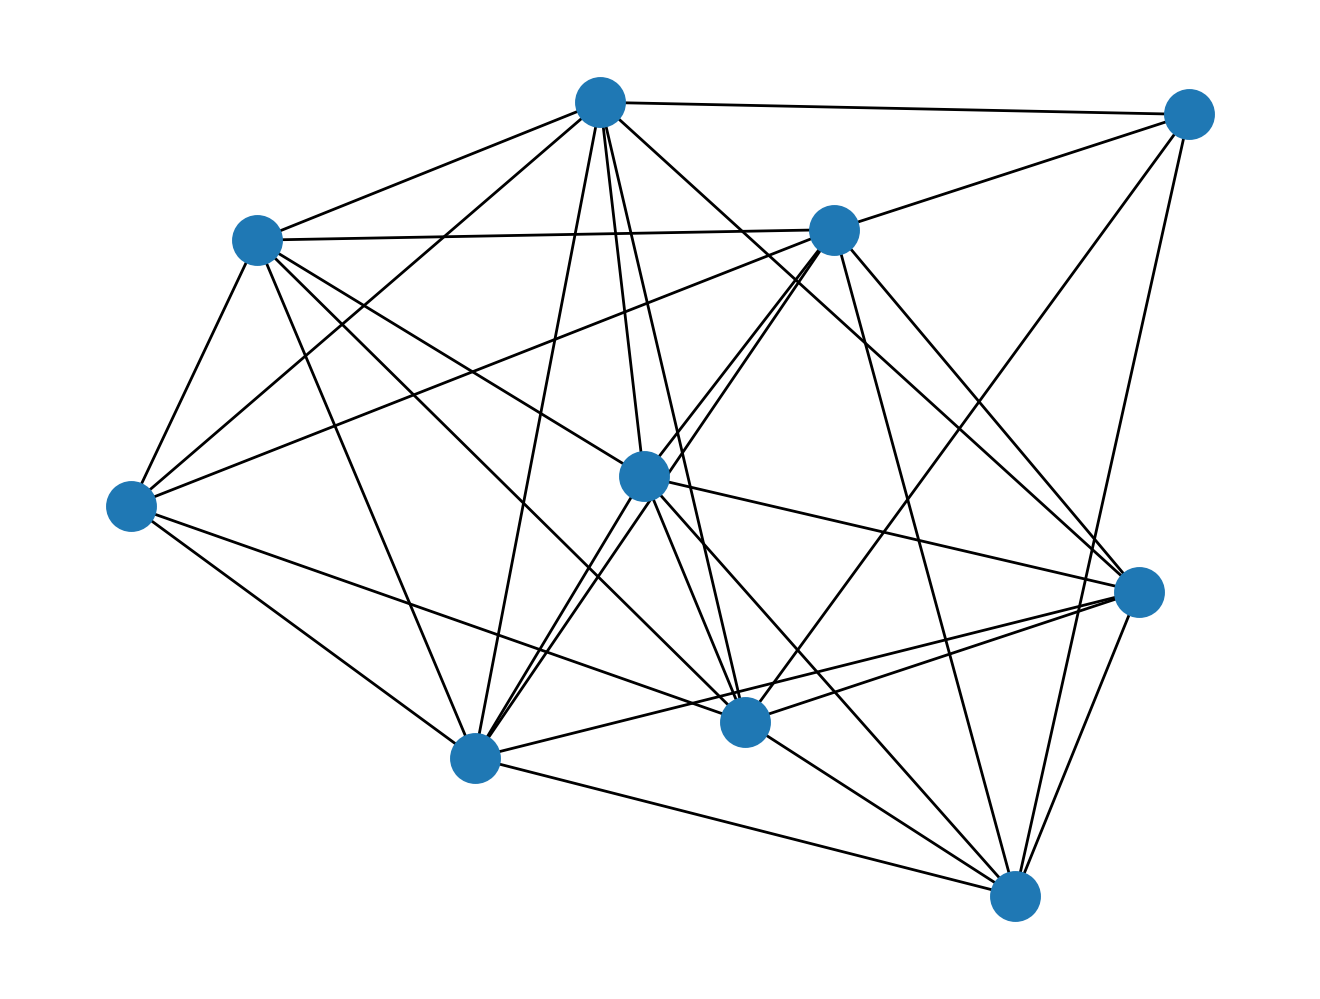

In [5]:
import numpy as np
from typing import List
from typing import Union


np.random.seed(42)
rand_mat = np.random.rand(10, 10)
rand_adj = (rand_mat + rand_mat.T) / 2
rand_adj[rand_adj < 0.35] = 0.0
np.fill_diagonal(rand_adj, 0)

g = nx.Graph(rand_adj)
nx.draw(g)

plt.show()

Напомню, что цель состоит в том, чтобы разбить множество вершин на два подмножества так, чтобы сумма весов ребер между двумя подмножествами была максимальной. Для этого понадобится функция, которая считает целевое значение для любого разбиения на два подмножества.

In [6]:
def score(g: nx.classes.graph.Graph, x: List[int]) -> (float):
    score = 0
    for e in g.edges(data=True):
        if x[e[0]] != x[e[1]]:
            score += e[2]["weight"]
    return score

Разобьем вершины на две группы случайным образом несколько раз и проверим, что функция работает корректно:

In [7]:
def split_random_node(random_seed: int) -> (List[int]):

    np.random.seed(random_seed)
    random_x = [
        1 if np.random.random() <= 0.5 else -1
        for _ in range(g.number_of_nodes())
    ]
    print(f"Random seed {random_seed}\tScore: {score(g, random_x):.2f}")

    return random_x

for random_seed in [2019, 2020, 2021]:
    random_x = split_random_node(random_seed)

Random seed 2019	Score: 7.78
Random seed 2020	Score: 7.23
Random seed 2021	Score: 9.38


Суть процесса отжига заключается в следующем:

1. генерируем начальное случайное решение (или получаем _feasible_ при помощи эвристик);
2. задаем начальную "температуру" -- некий глобальный метапараметр, суть которого станет ясна далее;
2. выполняем отжиг заданное число итераций;
    - выполняем случайую модификацию решения;
    - если значение функции стоимости для нового решения лучше, чем для старого, то принимаем его;
    - если нет, то все равно можем принять новое решение, но лишь с некоторой вероятностью, которая тем больше, чем выше температура и чем ближе друг к другу по оценке старое и новое решение.

Давайте реализуем это. В качестве функции, которая дает нам вероятность принять/отклонить новое решение, будем использовать [распределение Больцмана](https://en.wikipedia.org/wiki/Boltzmann_distribution):

$$
P_{acceptance} = e^{\frac{E_{new} - E_{old}}{T}}
$$

Видно, что эта величина может быть больше единицы в случае, когда новое решение лучше старого, но для нас это не проблема -- это просто будет значить, что мы точно принимаем новое решение!

In [8]:
from copy import copy

e_history = []
x = random_x
T = T_0 = 100
e = score(g, x)
e_history.append(e)

def bolzman(e_old: float, e_new: float, T: Union[int, float]) -> (float):
    return np.exp((e_new - e_old) / T)

def permute(x: List[int]) -> (List[int]):
    i = np.random.randint(0, len(x) - 1)
    x_new = copy(x)
    x_new[i] *= -1

    return x_new

for i in range(1500):
    new_state = permute(x)
    new_e = score(g, new_state)

    if new_e > e:
        e = new_e
        x = new_state
    else:
        prob = bolzman(e, new_e, T)
        if np.random.rand() <= prob:
            e = new_e
            x = new_state

    e_history.append(e)
    T = T_0 / (i + 1)

print(f"Final energy: {e:.2f}")

Final energy: 12.62


И посмотрим, как оно сходилось:

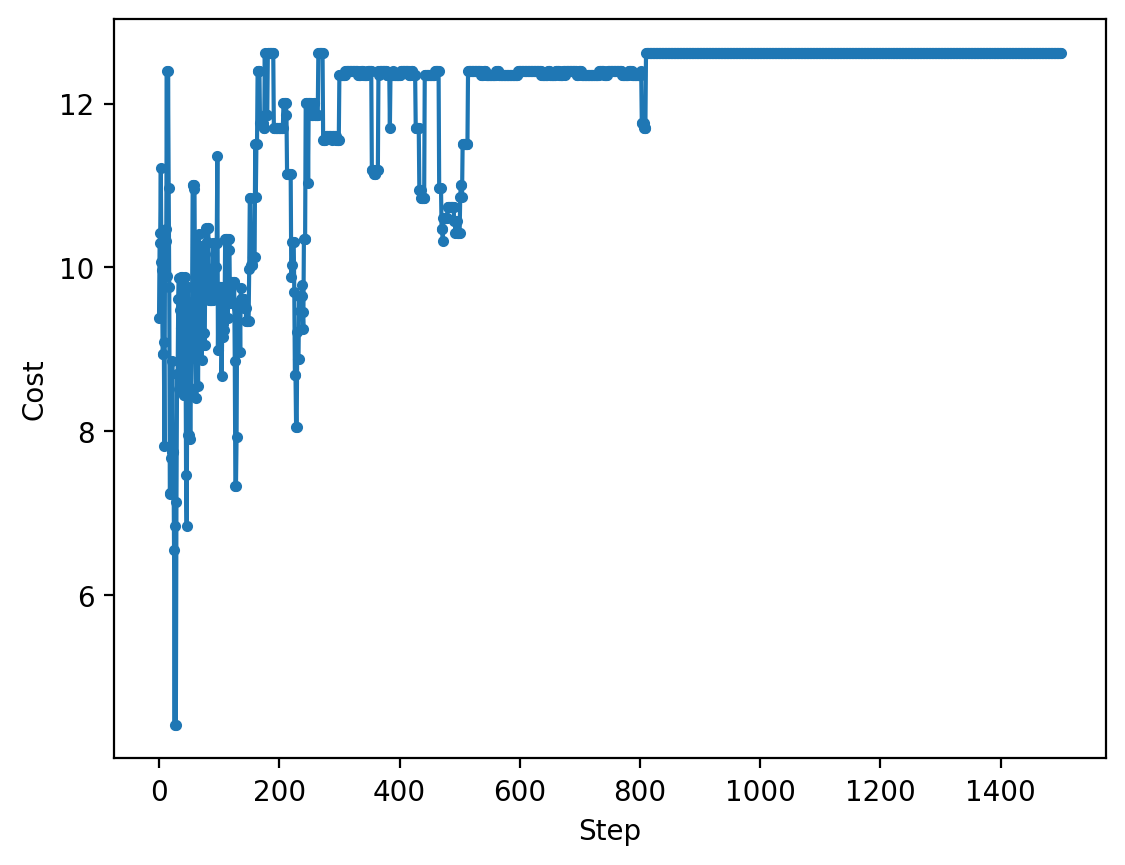

In [9]:
plt.plot(np.arange(len(e_history)), e_history, ".-")
plt.xlabel("Step")
plt.ylabel("Cost")
plt.show()

Видим, что в начале у нас был активный поиск решения, а ближе к концу переходы становились возможны, лишь если новое решение лучше. Этот процесс чем-то похож на кристаллизацию расплавов, когда изначально все частицы плавают в жидкости, но с уменьшением температуры они все более точно становится в те позиции, которые обеспечивают минимум свободной энергии кристалла. Именно поэтому данный алгоритм называется _имитацией отжига_ (_simulated annealing_).

Этот алгоритм неплохо находит оптимальные решение, но с ростом размерности задачи, а также пространства решений процесс "отжига" должен длиться все дольше и дольше, а температура уменьшаться все медленней.

## Заключение

В этой лекции мы узнали, что же это за такие _NP_-задачи, а также познакомились с примерами некоторых из них. Посмотрели, как эти задачи можно решать на классическом компьютере, и какие при этом есть ограничения. В следующих лекциях мы узнаем:

- как задачи комбинаторной оптимизации можно свести к решению модели Изинга (подробнее об этой модели -- в [отдельной лекции](../../problems/ru/ising.md))
- как задача Изинга переходит в задачу об основном состоянии квантовой системы
- как задачу об основном состоянии можно решать на квантовом компьютере разными способами:
  - через алгоритм _VQE_, основанном на [вариационных квантовых схемах](../../vqc/ru/vqc.md)
  - через алгоритм _QAOA_, который является квантовым аналогом алгоритма имитации отжига
  - на специальных квантовых компьютерах -- [квантовых аннилерах](../../dwave/ru/dwave.md)